In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
# ------------------------------------------------
# 1. Read CSV and form X, y with a 1-day shift
# ------------------------------------------------
df = pd.read_csv('data.csv')

# Assume that df has columns: Open, High, Low, Close
# Number of rows
n = len(df)

# Shift the target by 1 day:
#   X_t: [Open_t, High_t, Low_t]
#   y_t: Close_{t+1}
# So X will go up to the second to last row, and y from the 2nd row to the last
X = df[['Open', 'High', 'Low']].values[:-1]
y = df['Close'].values[1:]

print("X shape:", X.shape)  # (n-1, 3)
print("y shape:", y.shape)  # (n-1,)

X shape: (250, 3)
y shape: (250,)


In [4]:
# ------------------------------------------------
# 2. Scale (standardize) X and y
# ------------------------------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale the entire dataset (before split)
X_scaled = scaler_X.fit_transform(X)               # (n-1, 3)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)) # (n-1, 1)

In [5]:
# ------------------------------------------------
# 3. Split into train/test
#    shuffle=False to preserve chronology
# ------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.3, shuffle=False
)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # shape (N, 1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

# Check shapes
print("X_train_t:", X_train_t.shape)
print("y_train_t:", y_train_t.shape)
print("X_test_t:",  X_test_t.shape)
print("y_test_t:",  y_test_t.shape)

X_train_t: torch.Size([175, 3])
y_train_t: torch.Size([175, 1])
X_test_t: torch.Size([75, 3])
y_test_t: torch.Size([75, 1])


In [6]:
# ------------------------------------------------
# 4. Define GaussianMF and ANFIS classes
# ------------------------------------------------
class GaussianMF(nn.Module):
    """
    Gaussian membership function:
    MF(x) = exp(-0.5 * ((x - c)/sigma)^2)
    Parameters:
      centers: [mfs_per_input]
      sigmas:  [mfs_per_input]
    """
    def __init__(self, centers, sigmas):
        super(GaussianMF, self).__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas  = nn.Parameter(torch.tensor(sigmas,  dtype=torch.float32))

    def forward(self, x):
        """
        x shape: [batch_size]
        Returns a tensor with shape: [batch_size, mfs_per_input].
        """
        # Reshape x to [batch_size, 1] to correctly subtract centers
        x = x.unsqueeze(1)  # [batch_size, 1]
        return torch.exp(-0.5 * ((x - self.centers) / (self.sigmas + 1e-5))**2)


class ANFIS(nn.Module):
    def __init__(self, n_inputs=3, mfs_per_input=2):
        super(ANFIS, self).__init__()
        self.n_inputs = n_inputs
        self.mfs_per_input = mfs_per_input

        # (1) Create Gaussian membership functions for each input feature
        self.mfs = nn.ModuleList()
        for _ in range(n_inputs):
            centers = np.linspace(-1, 1, mfs_per_input)  # initial values
            sigmas  = np.full(mfs_per_input, 1.0)
            self.mfs.append(GaussianMF(centers, sigmas))

        # (2) Number of rules = (mfs_per_input^n_inputs), e.g. 2^3=8
        self.n_rules = (mfs_per_input ** n_inputs)

        # (3) Each rule has linear coefficients: w0 + w1*x1 + w2*x2 + w3*x3
        self.rule_weights = nn.Parameter(torch.zeros(self.n_rules, n_inputs + 1))
        nn.init.uniform_(self.rule_weights, a=-0.1, b=0.1)

    def forward(self, x):
        """
        x shape: [batch_size, n_inputs]
        """
        batch_size = x.shape[0]

        # (1) Compute membership values for each input
        mf_values = []
        for i in range(self.n_inputs):
            inp = x[:, i]  # i-th feature
            # Call GaussianMF -> returns [batch_size, mfs_per_input]
            mf_for_input_i = self.mfs[i](inp)
            mf_values.append(mf_for_input_i)

        # (2) Multiply membership values for each rule
        from itertools import product
        rule_indices = list(product(range(self.mfs_per_input), repeat=self.n_inputs))
        rule_fs = []
        for (i1, i2, i3) in rule_indices:
            fs = mf_values[0][:, i1] * mf_values[1][:, i2] * mf_values[2][:, i3]
            rule_fs.append(fs.unsqueeze(1))  # [batch_size, 1]
        rule_fs = torch.cat(rule_fs, dim=1)  # [batch_size, n_rules]

        # (3) Normalize firing strengths
        sum_fs = torch.sum(rule_fs, dim=1, keepdim=True) + 1e-8
        normalized_fs = rule_fs / sum_fs  # [batch_size, n_rules]

        # (4) Linear part for each rule: y_i = w0 + w1*x1 + w2*x2 + w3*x3
        #     Prepare x with a bias=1
        x_with_bias = torch.cat([torch.ones(batch_size, 1), x], dim=1)  # [batch_size, 4]

        # Each rule (n_rules) has 4 coefficients
        y_rules = []
        for r_i in range(self.n_rules):
            w = self.rule_weights[r_i]  # shape [4]
            # Multiply with x_with_bias -> shape [batch_size]
            out_r = torch.sum(x_with_bias * w, dim=1, keepdim=True)
            y_rules.append(out_r)
        y_rules = torch.cat(y_rules, dim=1)  # [batch_size, n_rules]

        # (5) Weighted sum with normalized firing strengths
        out = torch.sum(normalized_fs * y_rules, dim=1, keepdim=True)
        return out


In [7]:
# ------------------------------------------------
# 5. Create the model, define optimizer/loss function
# ------------------------------------------------
model = ANFIS(n_inputs=3, mfs_per_input=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
loss_history = []

In [8]:
# ------------------------------------------------
# 6. Training loop
# ------------------------------------------------
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass (scaled space)
    y_pred = model(X_train_t)
    # Compute loss (scaled space)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [50/1000], Loss: 0.773139
Epoch [100/1000], Loss: 0.489197
Epoch [150/1000], Loss: 0.292019
Epoch [200/1000], Loss: 0.166149
Epoch [250/1000], Loss: 0.093783
Epoch [300/1000], Loss: 0.056392
Epoch [350/1000], Loss: 0.038782
Epoch [400/1000], Loss: 0.030912
Epoch [450/1000], Loss: 0.027326
Epoch [500/1000], Loss: 0.025517
Epoch [550/1000], Loss: 0.024455
Epoch [600/1000], Loss: 0.023736
Epoch [650/1000], Loss: 0.023200
Epoch [700/1000], Loss: 0.022783
Epoch [750/1000], Loss: 0.022454
Epoch [800/1000], Loss: 0.022195
Epoch [850/1000], Loss: 0.021993
Epoch [900/1000], Loss: 0.021836
Epoch [950/1000], Loss: 0.021714
Epoch [1000/1000], Loss: 0.021618


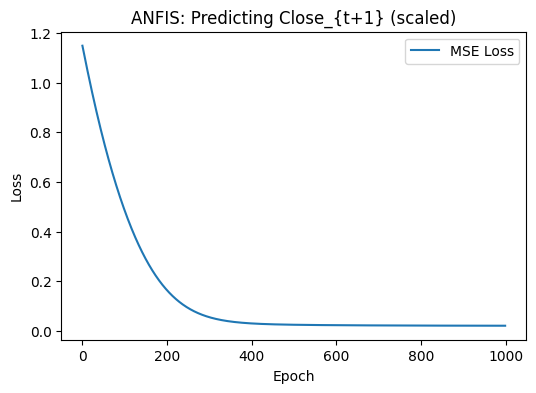

In [9]:
# ------------------------------------------------
# 7. Plot the training loss
# ------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history, label='MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ANFIS: Predicting Close_{t+1} (scaled)')
plt.legend()
plt.show()

In [10]:
# ------------------------------------------------
# 8. Evaluation on test set
# ------------------------------------------------
model.eval()
with torch.no_grad():
    y_pred_test_scaled = model(X_test_t)

# MSE/MAE in the "scaled" domain
mse_test_scaled = F.mse_loss(y_pred_test_scaled, y_test_t).item()
mae_test_scaled = F.l1_loss(y_pred_test_scaled, y_test_t).item()

print(f"Scaled Test MSE: {mse_test_scaled:.4f}")
print(f"Scaled Test MAE: {mae_test_scaled:.4f}")


Scaled Test MSE: 0.0229
Scaled Test MAE: 0.1210


In [11]:
# ------------------------------------------------
# 9. Invert scaling to compare with real Close_{t+1}
# ------------------------------------------------
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test_scaled.detach().numpy())
y_test_inv      = scaler_y.inverse_transform(y_test_t.detach().numpy())

# Compute MSE/MAE in the original scale
mse_test = np.mean((y_pred_test_inv - y_test_inv)**2)
mae_test = np.mean(np.abs(y_pred_test_inv - y_test_inv))

print(f"Original-scale Test MSE: {mse_test:.4f}")
print(f"Original-scale Test MAE: {mae_test:.4f}")


Original-scale Test MSE: 29463.9531
Original-scale Test MAE: 137.3735


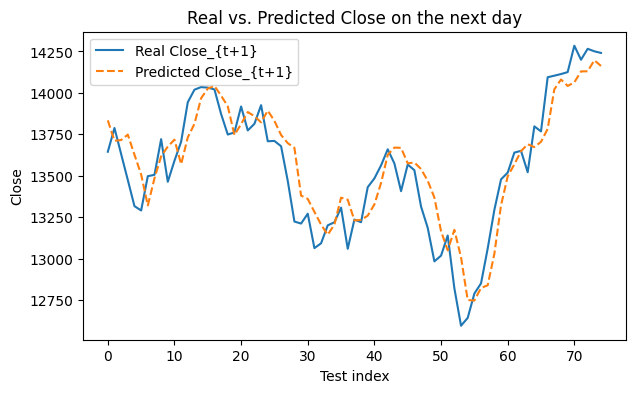

In [12]:
# ------------------------------------------------
# 10. Visual comparison: real vs predicted
# ------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(y_test_inv, label='Real Close_{t+1}')
plt.plot(y_pred_test_inv, label='Predicted Close_{t+1}', linestyle='--')
plt.xlabel('Test index')
plt.ylabel('Close')
plt.title('Real vs. Predicted Close on the next day')
plt.legend()
plt.show()